<center>
    <h2>SENG 474 Project</h2>
    <h1><i>Mood in Music: An Analysis of User-generated Spotify Playlists</i></h1>
    <h4>Lily Bryant (V00831776), Samantha Lai (V00846643), Shirley Wang (V00828517)</h4>
    <br><i>November 2018</i>
</center>
___

## Abstract

words

## Contents

<pre>
<b>1 Introduction</b>
<b>2 Related Work</b>
<b>3 Data Preprocessing</b>
    3.1 Set-up and Authorization
    3.2 Data Gathering
    3.3 WEKA
<b>4 Visualization</b>
    4.1 Set-up and Data Formatting
    4.2 Attribute Heatmap
    4.3 Attribute Box Plots
    4.4 Attribute Histograms
<b>5 Data Mining</b>
    5.1 Trees
    5.2 Logistic Regression
    5.3 JRip
    5.4 SMO
    5.5 Other Classifiers
<b>6 Evaluation
7 Conclusion
8 References</b>
</pre>




## 1 Introduction

With over 30 million songs and 2 billion playlists from around the world, Spotify is a music streaming platform that processes and stores an immense amount of musical data [1][2]. The extent of its global influence can be seen from the over 180 million monthly users from countries in Europe, the Americas, Oceania, and parts of Africa and Asia. From hit lists of the very most popular current songs to weekly tailored playlists for users, Spotify has a wealth of data and takes advantage of this by utilizing many data mining and machine learning algorithms to analyze every song [3]. Part of their song analysis involves breaking down each song into bar by bar information, such as rhythm and pitch. This precise processing results in various 'scores', such as a song's danceability or acousticness, which is then used for their recommendation system. Through the Spotify API for developers [4], all of this song information is available publicly for free.

Although all of this analysis is extremely valuable for predictions, a lot of insight can be gained from the user-generated data Spotify possesses. Users save songs they enjoy and, perhaps more importantly, group like songs together in playlists. The analysis of each song’s features is extremely valuable for predictions and, together with the user-generated data, allows data scientists to gain insight into musical patterns. By examining the typical attributes of songs in a type of playlist, it is possible to learn interesting patterns about the prototypical song of the playlist – that is, what aspects of the song make it more likely to be featured in that playlist.

One interesting area of analysis in music is the mood or energy a song has. A cheery, upbeat song might have an exciting energy and remind you of a summer day, while a calm, relaxing song may make you sleepy and want to curl up with a book. But how do we quantify this? What makes a song sound upbeat versus calm? Using Spotify's audio analysis scoring system and user-generated playlists containing keywords relating to this contrast, we will build classification models to hopefully answer this question. Our aim is to determine which song attributes are most correlated with whether the song has an upbeat mood or a calm mood.

Given that music for specific purposes such as sleep/study/relaxing playlists or exercise/workout/party playlists are commonly used by many people, having a deeper understanding of how song features affect mood would provide a tangible benefit. For example, artists may want to tailor their music to specific categories to target a certain audience. Algorithms could also more accurately generate playlists containing only songs of a certain mood.

Our dataset of upbeat and calm songs is generated by selecting all the songs in a playlist if the playlist has a keyword in the title. However, searching for a keyword in playlist titles comes with some limitations. The search function may return the playlists most relevant to the keyword or results that other users found to best fit the keyword. Relying on user opinion and user-generated playlists may affect the consistency of the dataset. These effects can be mitigated by swapping out any playlist that varies significantly from others in its genre, sampling a larger number of playlists to minimize outliers, or increasing the number of related keywords used. Another limitation is that the number of song instances in our training dataset is constrained by the number that Weka can handle [5]. Future work could be conducted with more powerful machine learning to allow for larger datasets. 

The following sections of the report are organized as follows. In Section 2, we examine similar studies that explored interesting patterns in Spotify music datasets with machine learning algorithms. Next, we describe our data gathering methods through the Spotify Web API in Section 3. This section also discusses the steps we took to convert the data to a form that can be used with classifiers in Weka. Section 4 illustrates interesting patterns and correlations between song attributes that can be seen in our raw data. In Section 5, we use various classifiers in Weka to discover which attributes are most important in determining the song’s mood. Finally, we evaluate the accuracy of the classifiers in Section 6 and make our conclusions in Section 7.

## 2 Related Work

Spotify provides a web API for developer use [4]. Developers are able to register their applications through Spotify, so they may access song, playlist, and user data. Many other projects have used the API to attain song data. Three were examined to provide insight to its use and possibilities: “Finding Emotion in Music with Python” [6], “Analyzing Spotify API Song Data Pt. 1” [7], and “Spotify Music Data Analysis” [8].

“Finding Emotion in Music with Python” used Spotify data to train a model for predicting whether a song was ‘happy’ or ‘sad’ [6]. Using the song attributes data, Vollebregt gathered the ‘valence’ and ‘energy’ values for songs in playlists user-labelled as ‘happy’ or ‘sad’, and observed a relationship between the attributes and songs with these labels. 

The attributes of jazz, rock, and hip-hop songs were explored in “Analyzing Spotify API Song Data Pt. 1” [7]. Song attributes ‘danceability,’ ‘acousticness,’ and ‘valence’ were plotted in 2- and 3-D space to view the differences in the attributes in these genres. This exploration took extra steps in preprocessing to ease data collection.

“Spotify Music Data Analysis” examined trends in music over the past 20 years [8]. Song attributes, artist information, and album data were gathered for each track, and used to sort the tracks by release year, examine trends in song attributes, and analyze genre popularity. 
Since the project was coded in Python, the Spotipy library was used to simplify data access [9]. Spotipy’s library allows users to use Spotify’s API and provides some examples of use; of the projects examined, “Finding Emotion in Music with Python” also relied on the Spotipy library [6].

## 3 Data Preprocessing

### 3.1 Spotify API Set-up and Authorization

In order to gain access to the Spotify Web API, we created a developer account and registered our application through the Spotify dashboard. This created a client ID (a unique identifier of the application) and a client secret (a key that is passed in during secure calls to the Spotify Accounts and Web API services), which we could use to obtain an authorization token.

In the code below, we imported the necessary libraries and got an access token with a Spotipy function to authenticate calls to the Spotify API.

In [75]:
import sys
import os
import spotipy
import spotipy.util as util

SPOTIPY_CLIENT_ID='b0b5be645e864041a2fad5d7ccdf0531'
SPOTIPY_CLIENT_SECRET='86078e2a70f0476e9ec2785ed822b05e'

token = util.oauth2.SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
cache_token = token.get_access_token()

spotify = spotipy.Spotify(auth=cache_token)

### 3.2 Data Gathering

The following code blocks utilize the Spotify API to pull detailed audio analysis of tracks. These tracks are found by searching for playlists which contain relevant search words. To look for meaningful patterns, our dataset is split into two categories: “upbeat” and “calm”. Each search category contains six keywords that were used to search Spotify for playlists (Figure 1). The upbeat category contains words that one might commonly associate with higher energy music, while the calm category contains those associated with lower energy music. Each keyword was searched on Spotify via the API and the top 5 playlist results were returned. Then, the detailed audio features from each track in playlist was stored. After collection, all track instances and their relevant features (Figure 2) were formatted and saved into data.csv.

<br>

| Calm Keywords |  | Upbeat Keywords |
|---|---|---|---|
| calm |    | upbeat |
| relax |    | party |
| chill |    | dance |
| spa |    | energy |
| sleep |    | energetic |
| peaceful |    | hype |

<br><center><b>Figure 1:</b> <i>upbeat and calm keywords</i>, the list of words used for searching Spotify playlists</center>

<br><br>

| Attribute Name | Spotify API Description | Maximum | Minimum |
|---|---|
| danceability | How suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. | 1.0 | 0.0| 
| energy | Features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. | 1.0 | 0.0 |
| key | Estimated overall key. Integers map to pitches using standard Pitch Class notation (0 = C, 1 = C♯/D♭, 2 = D, and so on.)  | 10 | 0 |
| loudness | Overall loudness of a track in decibels (dB) averaged across the entire track.  | 1.0 | 0.0 |
| mode | Modality (major or minor) of a track. | 1 (Major) | 0 (Minor) |
| speechiness | The presence of spoken words in a track. | 1.0 | 0.0 |
| acousticness | A confidence measure of whether the track is acoustic. | 1.0 | 0.0 |
| instrumentalness | Predicts whether a track contains no vocals.  | 1.0 | 0.0 |
| liveness | Detects the presence of an audience in the recording. | 1.0 | 0.0 |
| valence | Musical positiveness conveyed by a track. | 1.0 | 0.0 |
| tempo | Overall estimated tempo of a track in beats per minute (BPM). | 1750.0 | 0.0 |
| duration_ms | The duration of the track in milliseconds. | any | 0 |
| time_signature | Estimated overall time signature of a track. | any | 0 |
| mood | Our binary mood classification. | 1 (upbeat) | 0 (calm) |

<br><center><b>Figure 2:</b> <i>attributes</i>, the list of attributes used for classification where "mood" is the class value

In [ ]:
attribs = [
            "danceability",
            "energy",
            "key",
            "loudness",
            "mode",
            "speechiness",
            "acousticness",
            "instrumentalness",
            "liveness",
            "valence",
            "tempo",
            "duration_ms",
            "time_signature",
            "mood"
          ]

upbeat_keywords = [
            "upbeat",
            "party",
            "dance",
            "energy",
            "energetic",
            "hype",
]

calm_keywords = [
            "calm",
            "relax",
            "chill",
            "spa",
            "sleep",
            "peaceful",
]

In [ ]:
id_list = []

def get_tracks(search_term, lim, mood):
    tracks = []
    
    for p in spotify.search(search_term, limit=lim, offset=0, type='playlist', market='CA')["playlists"]["items"]:
        for t in spotify.user_playlist("spotify", p["id"])["tracks"]["items"]:
            t_id = t["track"]["id"]
            
            # append only new tracks
            if t_id not in id_list:
                id_list.append(t_id)        
                
                # skip tracks that API cannot find
                try:
                    info = spotify.audio_features(t_id)[0]
                except:
                    continue
                
                info["id"] = t_id
                info["mood"] = mood
                tracks.append(info)

        print("playlist completed for", search_term)
    return tracks

In [ ]:
upbeat_tracks = []
for word in upbeat_keywords:
    upbeat_tracks += get_tracks(word, 5, 1)

In [ ]:
calm_tracks = []
for word in calm_keywords:
    calm_tracks += get_tracks(word, 5, 0)

In [ ]:
data = upbeat_tracks + calm_tracks

In [ ]:
import csv

with open('data.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames=attribs, extrasaction="ignore")

    writer.writeheader()
    for track in data:
        writer.writerow(track)

### Track Results

|  |  |
|--|--|
| Upbeat Tracks |  1877 |
| Calm Tracks | 2050 |
| Total Tracks | 3927 |

### 3.3 WEKA

We select the Explorer application from the Weka GUI Chooser. In the “Preprocess” tab, we import the data by opening the data.csv file. Since most of the classifiers are only applicable to datasets with nominal attributes, the unsupervised attribute filter NumericaltoNominal is applied to the “mood” attribute to allow for discrete classification. Using the unsupervised attribute filter Normalize, all of the features are scaled to a value between 0 and 1 to allow for more meaningful visualization. The normalized dataset was exported as data_normal.csv for visualization (Section 4). Additionally, data mining techniques were applied to the dataset in Section 5. 

## 4 Visualization

### 4.1 Set-up and Data Formatting

The following code blocks use Python libraries Pandas, MatPlotLib, and Seaborn to prepare the normalized raw dataset for visualization in the following sections.

In [78]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [100]:
df = pd.read_csv('data_normal.csv', encoding='unicode_escape')
df.head()

upbeat_df = df[df.mood == 1]
calm_df = df[df.mood == 0]

corr = dataset.corr()

### 4.2 Attribute Heatmap

Even before classification, we immediately see interesting patterns in our data. Energy, loudness, valence, and danceability show a high positive correlation with mood. Thus, higher scores in these attributes imply a track is more upbeat. Conversely, acousticness and instrumentalness show a large negative correlation indicating that these attributes result in a more calm sound overall. Further, we see that the key, mode, time signature, and duration of tracks are nearly independent of mood. We also see that songs with more vocals  (speechiness), faster tempo, as well as live tracks, have some correlation with being  considered upbeat.

The heatmap below illustrates these patterns (see Figure 3). Correlation coefficients are listed over corresponding attribute pairs.

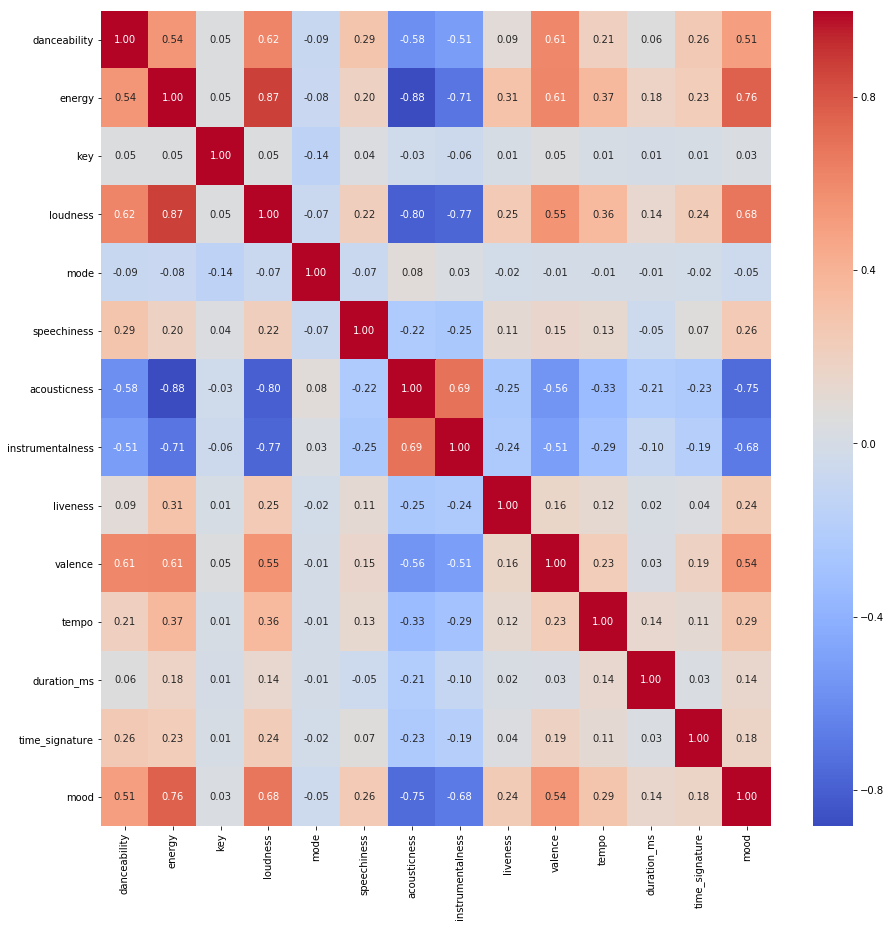

In [94]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.show()

<center><b>Figure 3:</b> <i>attribute heatmap</i>, the list of attributes used for classification compared against each other

### 4.3 Attribute Box Plots

Below are box plots showing the attributes within each mood category. The plots correspond to upbeat and calm instances, respectively (Figures 4 and 5). The mood, mode, and time_signature attributes were dropped as the values were discrete, making visualization trivial. As above, the attributes of danceability, energy, loudness, and valence have relatively high medians in the upbeat plot, while the calm plot shows low values. Even more noticeably, the contrast of high instrumentalness and acousticness scores in the calm plot against the upbeat plots illustrates how key these traits are in the making of a calm, relaxing sound.

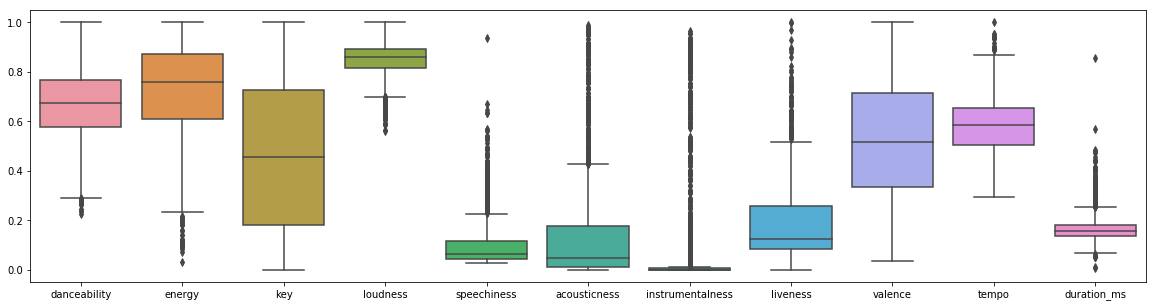

In [130]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=upbeat_df.drop(["mood", "mode", "time_signature"], axis=1))
plt.show()

<center><b>Figure 4:</b> <i>upbeat mood box plot</i>, the distribution of attribute values for upbeat tracks

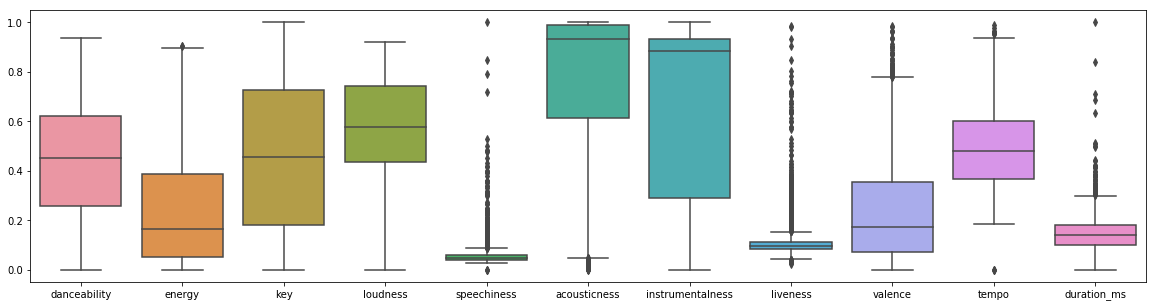

In [131]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=calm_df.drop(["mood", "mode", "time_signature"], axis=1))
plt.show()

<center><b>Figure 5:</b> <i>calm mood box plot</i>, the distribution of attribute values for calm tracks

### 4.4 Attribute Histograms

Danceability, energy, valence, loudness, acousticness, and instrumentalness were chosen to be visualized in histograms. From the heatmap in Figure 3, these attributes have some variance. This is further illustrated in the histograms. Danceability is significantly higher in ‘upbeat’ songs, while energy is lower in ‘calm’ songs. The valence of ‘calm’ songs is generally quite low, while it varies for ‘upbeat’ songs. Perhaps the most interesting histogram is loudness: ‘upbeat’ songs clearly score higher in loudness than calm songs. Acousticness and instrumentalness share similar patterns , which is illustrates how acoustic and instrumental music is considered more calming. However ‘upbeat’ songs are found to typically contain vocals, contributing to the massive spike in the instrumentalness graph.  

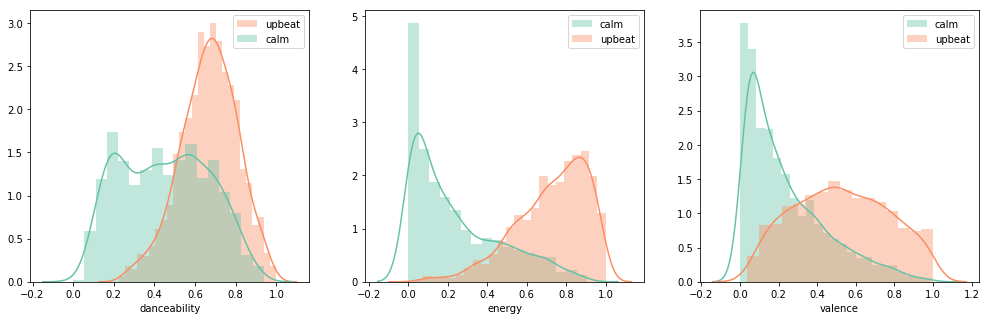

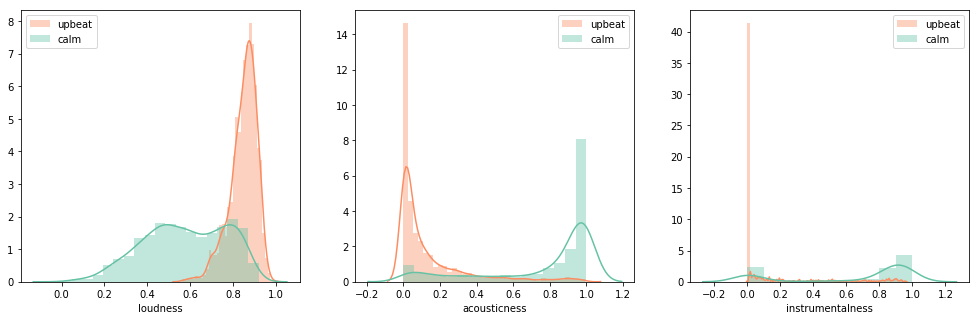

In [151]:
colours = {"calm": sns.color_palette("Set2")[0], "upbeat": sns.color_palette("Set2")[1]}
    
fig, ax = plt.subplots()
fig.set_size_inches(17, 5)
plt.subplot(1,3,1)
sns.distplot(upbeat_df.danceability, label="upbeat", color=colours["upbeat"])
sns.distplot(calm_df.danceability, label="calm", color=colours["calm"])
plt.legend()

plt.subplot(1,3,2)
sns.distplot(calm_df.energy, label="calm", color=colours["calm"])
sns.distplot(upbeat_df.energy, label="upbeat", color=colours["upbeat"])
plt.legend()

plt.subplot(1,3,3)
sns.distplot(calm_df.valence, label="calm", color=colours["calm"])
sns.distplot(upbeat_df.valence, label="upbeat", color=colours["upbeat"])
plt.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(17, 5)
plt.subplot(1,3,1)
sns.distplot(upbeat_df.loudness, label="upbeat", color=colours["upbeat"])
sns.distplot(calm_df.loudness, label="calm", color=colours["calm"])
plt.legend()

plt.subplot(1,3,2)
sns.distplot(upbeat_df.acousticness, label="upbeat", color=colours["upbeat"])
sns.distplot(calm_df.acousticness, label="calm", color=colours["calm"])
plt.legend()

plt.subplot(1,3,3)
sns.distplot(upbeat_df.instrumentalness, label="upbeat", color=colours["upbeat"])
sns.distplot(calm_df.instrumentalness, label="calm", color=colours["calm"])
plt.legend()
plt.show()

## 5 Data Mining

Using Weka, the following classifiers were run on the normalized dataset. The ‘mood’ attribute was chosen as the class value, and was converted to nominal values. A mood value of 0 indicated calmness and a value of 1 indicated upbeatness. Each run was performed with stratified 10-fold cross-validation, to improve the accuracy of the classifier. 10-fold cross-validation was considered sufficient for the accuracy we desired because it generally resulted in a less biased model than the other test options. Default parameters for all classifiers were used unless otherwise noted.

In the following sections, we discuss the models built by the J48, RandomTree, Logistic, JRip, and SMO classifiers and consider which song attributes were evaluated to be most important in dictating the song’s mood in each model. The accuracies of all classifiers run are shown in Figure 6.


| Classifier  | Correctly Classified Instances  |
|---|---|
| RandomTree  | 85.2305%  |
| IBK | 85.3832% |
| J48 | 87.9043% |
| Decision Table | 87.9043% |
| ADABoostM1  | 88.3372% |
| Naive Bayes | 88.821% |
| SMO | 88.821% |
| Logistic  | 88.9228% |
| Random Forest | 89.916 % |
| JRip | 88.9992%  |

<center><b>Figure 6:</b> <i>classifier results</i>, the percentage of correctly classified instances for each classifier

### 5.1 Trees

We ran two classifiers algorithms from Weka’s “trees” folder – J48 and RandomTree. J48 generates a pruned or unpruned decision tree based on the standard C4.5 algorithm, and RandomTree constructs the tree by evaluating K randomly chosen attributes at each node. We set the “reducedErrorPruning” parameter in J48 to true in order to reduce the size and complexity of the tree through post-pruning. The following trees were visualized with the “prefuseTree” package plug-in. The top sections of the trees can be seen below.

We note that J48 chose energy as the root node while random tree chose valence. Energy as the root node has the lowest entropy as it results in better split, and we can see from the results that J48 has a higher percentage of correctly classified instances. Overall, energy, valence, instrumentalness and acousticness were the attributes most frequently seen near the root of the trees.

<br>
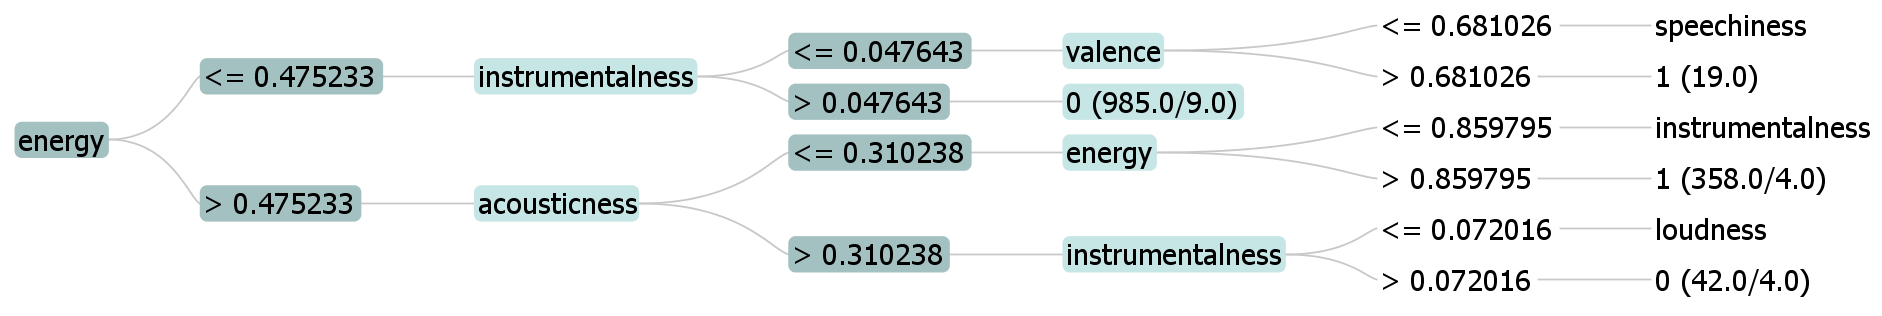

<center><b>Figure 7:</b> <i>J48 tree</i>

<br>
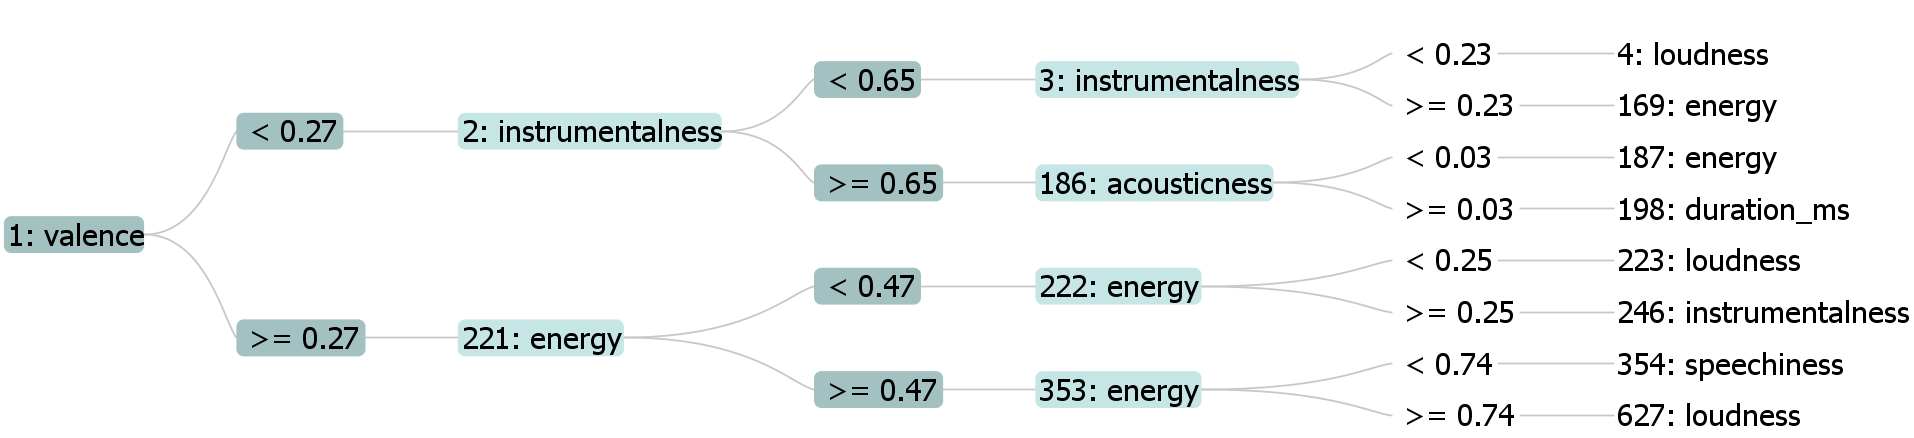

<center><b>Figure 8:</b> <i>RandomTree tree</i>

### 5.3 Logistic Regression

The JRip algorithm is a rule-based classifier that predicts a class value depending on the antecedents and consequents. It produced a set of rules, shown in Figure ***. The numbers in brackets following each rule represents the coverage of the training data. From these rules, it becomes clear that the energy of upbeat songs is quite likely to be higher than the energy of calm songs. Of the 13 attributes, only mode, key, and time signature were not represented in the rules. 

<br>
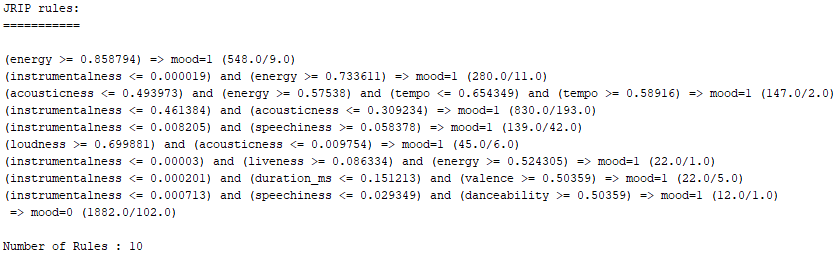

<center><b>Figure 9:</b> <i>JRip pruned ruleset</i>

### 5.4 SMO

SMO is an optimization algorithm for training support vector machines (SVMs). The attribute weights indicate that energy, duration, danceability, and speechiness are heavily correlated with upbeat moods in songs, while instrumentalness, acousticness, and time signature are negatively correlated.

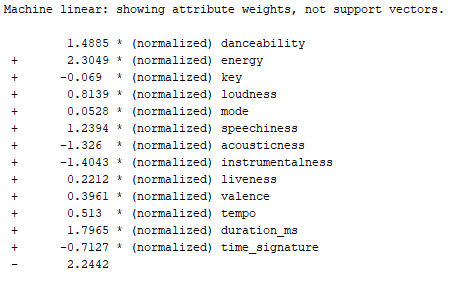

<center><b>Figure 10:</b> <i>SMO attribute weights</i>

## 6 Evaluation

## 7 Conclusion

Through the raw data visualizations and data mining models, we discovered that songs that were considered upbeat according to user-created playlists on Spotify consistently had higher scores of energy and danceability. Calm songs, on the other hand, tended to be higher in instrumentalness and acousticness. (give exact values). We verified the accuracy of our models by ???

## 8 References

[1] Spotify. “Music for Everyone - Spotify,” spotify [Online]. Available: https://www.spotify.com/ca-en/. [Accessed: Nov. 27, 2018].

[2] C. Smith (Nov. 10, 2018). “72 Amazing Spotify Stats and Facts (September 2018),” DMR [Online] Available: https://expandedramblings.com/index.php/spotify-statistics/. [Accessed: Nov. 28, 2018].

[3] S. Y. Coleman (2016). Data-mining opportunities for small and medium enterprises with official statistics in the UK. Journal of Official Statistics, 32(4), 849-865. 

[4] Spotify. “Spotify for Developers” developer.spotify.com [Online]. Available: https://developer.spotify.com/. [Accessed: Nov. 27, 2018].

[5] Machine Learning Group at the University of Waikato, “WEKA: Waikato Environment for Knowledge Analysis.” [Online]. Available: http://www.cs.waikato.ac.nz/ml/index.html [Accessed: Nov. 28, 2018]

[6] B. Vollebregt (Dec. 5, 2017). “Finding Emotion in Music with Python,” nitratine.net [Online] Available: https://nitratine.net/blog/post/finding-emotion-in-music-with-python/. [Accessed: Nov. 27, 2018].

[7] T. Nguyen, K. Towfiq, and A. Xu (Oct. 14, 2017). “Analyzing Spotify API Song Data Pt. 1,” inertia7 [Online]. Available: https://www.inertia7.com/projects/76. [Accessed: Nov. 27, 2018].

[8] AsTimeGoesBy111 (Sept. 18, 2017). “Spotify Music Data Analysis,” github [Online]. Available: 
https://github.com/AsTimeGoesBy111/Spotify-Music-Data-Analysis. [Accessed: Nov. 27, 2018].

[9] P. Lamere (2014). “Welcome to Spotipy!,” spotipy.readthedocs.io [Online]. Available: https://spotipy.readthedocs.io/en/latest/ [Accessed: Nov. 27, 2018]. 